###Flopy3 working stack demo

A short demonstration of some of the `flopy3` awesomeness

In [1]:
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
import pandas as pd

import flopy

###Model Inputs

In [2]:
# first lets load an existing model
model_ws = "data"
ml = flopy.modflow.Modflow.load("freyberg",model_ws=model_ws,verbose=True)
ml.exe_name = "mf2005"
ml.dis.sr.rotation = 15


Creating new model with name: freyberg
--------------------------------------------------

Parsing the namefile --> data/freyberg.nam
Setting filehandles:

--------------------------------------------------
External unit dictionary:
{51: <flopy.utils.mfreadnam.NamData object at 0x109d47ed0>, 2: <flopy.utils.mfreadnam.NamData object at 0x109d47c90>, 11: <flopy.utils.mfreadnam.NamData object at 0x109d47cd0>, 13: <flopy.utils.mfreadnam.NamData object at 0x109d47d10>, 14: <flopy.utils.mfreadnam.NamData object at 0x109d47e90>, 15: <flopy.utils.mfreadnam.NamData object at 0x109d47d50>, 18: <flopy.utils.mfreadnam.NamData object at 0x109d47dd0>, 19: <flopy.utils.mfreadnam.NamData object at 0x109d47e10>, 20: <flopy.utils.mfreadnam.NamData object at 0x109d47d90>, 53: <flopy.utils.mfreadnam.NamData object at 0x109d47f50>, 52: <flopy.utils.mfreadnam.NamData object at 0x109d47f10>, 27: <flopy.utils.mfreadnam.NamData object at 0x109d47e50>}
--------------------------------------------------

loadin

Let's looks at some plots

plotting LPF package Util3d instance: hani
plotting LPF package Util3d instance: wetdry
plotting LPF package Util3d instance: vka
plotting LPF package Util3d instance: vkcb
plotting LPF package Util3d instance: hk
plotting LPF package Util3d instance: sy
plotting LPF package Util3d instance: ss


/Users/jwhite/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


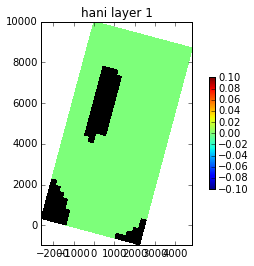

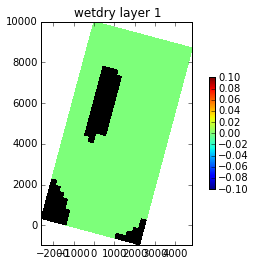

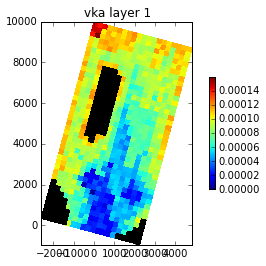

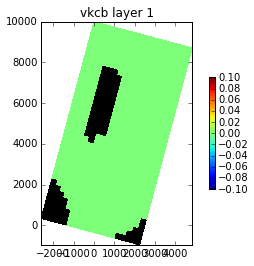

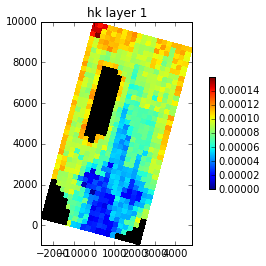

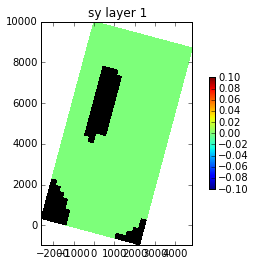

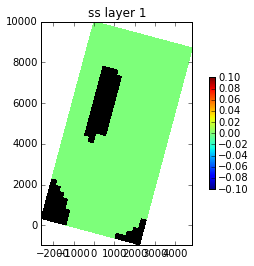

In [3]:
ml.lpf.plot()

plotting DIS package Util2d instance: top
plotting DIS package Util3d instance: _ModflowDis__thickness
plotting DIS package Util3d instance: botm


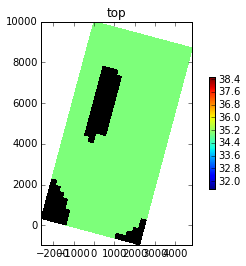

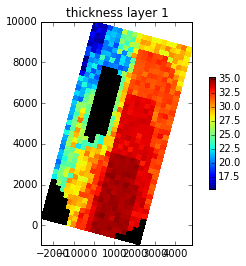

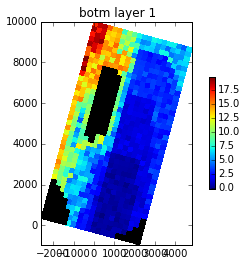

In [4]:
ml.dis.plot()

plotting RIV package mflist instance: stress_period_data


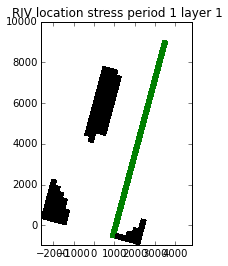

In [5]:
ml.riv.plot()

Let's write a giant shapefile with all model inputs

In [6]:
ml.to_shapefile(os.path.join(model_ws,"freyberg.shp"))

Let's also write a netCDF file with all model inputs

In [7]:
ml.export(os.path.join(model_ws,"freyberg.nc"))

('2015-12-03 10:46:41.505369 WARNING: removing existing nc file: data/freyberg.nc\n',)
('2015-12-03 10:46:41.507770 starting: initializing attributes\n',)
('2015-12-03 10:46:41.507850 finished: initializing attributes, took: 0:00:00.000080\n',)
('2015-12-03 10:46:41.507879 starting: getting 3D array for botm\n',)
('2015-12-03 10:46:41.507952 finished: getting 3D array for botm, took: 0:00:00.000073\n',)
('2015-12-03 10:46:41.508048 starting: creating variable: botm\n',)
('2015-12-03 10:46:41.508158 starting: initializing geometry\n',)
('2015-12-03 10:46:41.509575 starting: building grid crs using proj4 string: +init=EPSG:4326\n',)
('2015-12-03 10:46:41.509758 finished: building grid crs using proj4 string: +init=EPSG:4326, took: 0:00:00.000183\n',)
('2015-12-03 10:46:41.510291 starting: projecting grid cell center arrays from <pyproj.Proj object at 0x10b668668> to <pyproj.Proj object at 0x10b668e88>\n',)
('2015-12-03 10:46:41.510419 finished: projecting grid cell center arrays from <py

###Run the model

In [8]:
ml.run_model()

FloPy is using the following executable to run the model: /Users/jwhite/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/12/03 10:46:42

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/12/03 10:46:42
 Elapsed run time:  0.008 Seconds

  Normal termination of simulation


(True, [])

###Output inspection

First, let's look at the list file

In [9]:
mfl = flopy.utils.MfListBudget(os.path.join(model_ws,"freyberg.list"))
df_flux, df_vol = mfl.get_dataframes(start_datetime="10-21-2015")
df_flux # multiindex columns

,STORAGE_IN,CONSTANT_HEAD_IN,WELLS_IN,RIVER_LEAKAGE_IN,RECHARGE_IN,TOTAL_IN,STORAGE_OUT,CONSTANT_HEAD_OUT,WELLS_OUT,RIVER_LEAKAGE_OUT,RECHARGE_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
2015-10-21 00:00:10.000022,0,0,0,0.004194,0.0695,0.073694,0,0.004735,0.02205,0.04691,0,0.073695,-6.407500e-07,-0


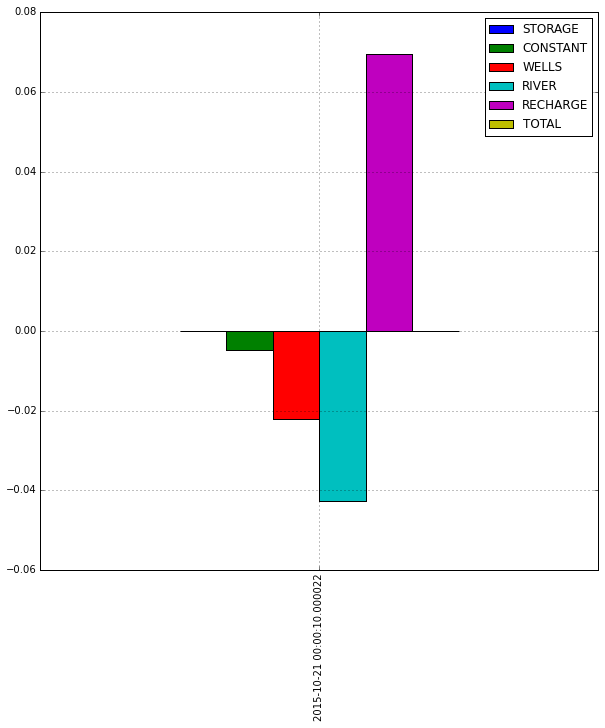

In [21]:
groups = df_flux.groupby(lambda x:x.split('_')[-1],axis=1).groups
df_flux_in = df_flux.loc[:,groups["IN"]]
df_flux_in.columns = df_flux_in.columns.map(lambda x:x.split('_')[0])

df_flux_out = df_flux.loc[:,groups["OUT"]]
df_flux_out.columns = df_flux_out.columns.map(lambda x:x.split('_')[0])


df_flux_delta = df_flux_in - df_flux_out
#df_flux_delta = df_flux.loc[:,"in"] - df_flux.loc[:,"out"]
df_flux_delta.plot(kind="bar",figsize=(10,10),grid=True)

Let's look at head

In [22]:
# if you pass the model instance, then the plots will be offset and rotated
h = flopy.utils.HeadFile(os.path.join(model_ws,"freyberg.hds"),model=ml)

/Users/jwhite/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


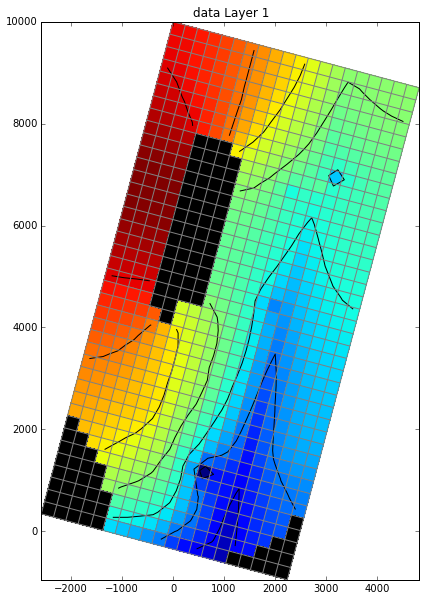

In [23]:
h.plot(contour=True,grid=True,figsize=(10,10))

In [24]:
#let's write these heads to shapefile
h.to_shapefile(os.path.join(model_ws,"freyburg_head.shp"))

###For more fine-grained plotting control with `ModelMap` - see the other notebooks